***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [6. Deconvolution in Imaging](6_0_introduction.ipynb)  
    * Previous: [6.3 CLEAN Implementations](6_3_clean_flavours.ipynb)  
    * Next: [6.5 Source Finding and Detection](6_5_source_finding.ipynb)

***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [2]:
import matplotlib.image as mpimg
from IPython.display import Image
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

/Users/denghui/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [ ]:
from IPython.display import HTML
HTML('../style/code_toggle.html')

***

## 6.4 残图和图像质量 Residuals and Image Quality<a id='deconv:sec:iqa'></a>

使用“CLEAN”或者其它去卷积方法生成比脏图更好的图像（除了去卷积失控的情况），然而，什么才算是“好”的图像，并没有一个很好的定义，事实上，就几乎完全没有定义过。当我们在谈到综合成像的图像质量时，我们很少使用定量指标，而是依靠人的主观判断。我们知道这并不科学。计算机视觉发展了几十年，已经研究出了一批图像质量评价的客观指标和技术。随着自动校准、成像，以及去卷积管线的使用，未来这些图像质量客观评价方法终将应用到射电天文领域。

Using `CLEAN` or other deconvolution methods produces 'nicer' images than the dirty image (except when deconvolution gets out of control). What it means for an image to be 'nicer' is not a well defined metric, in fact it is almost completely undefined. When we talk of the quality of an image in synthesis imaging we rarely use a quantitative metric, but instead rely on the subjective opinion of the people looking at the image. I know, this is not very scientific. The field of computer vision has been around for decades, this is a field which has developed the objective metrics and techniques for image quality assessment. At some point in the future these methods will need to be incorporated into radio astronomy. This is bound to happen as we have moved to using automated calibration, imaging, and deconvolution pipelines.

在可见度数据成图的时候，有两个问题需要回答：

* 什么时候终止去卷积？
* 好图是什么样子的？

We have two some what related questions we need to answer when we are reducing visibilities into a final image:

* When should you halt the deconvolution process?
* What makes a good image?

在[$\S$ 6.2 &#10142;](6_2_clean.ipynb)，我们讨论了怎样使用迭代“CLEAN”的去卷积方法，从噪声中分离出天空模型，但是，我们没有涉及到什么时候停止处理这一问题，而且对这个停止点也没有很明确的定义。通常都是临时决定去卷积的迭代次数或者残图要达到的流量水平，通过调整“CLEAN”参数来设置这些停止条件，直到生成“好”图。有些阵列的可见度流量已经被校准，信号会固定到某些流量水平上，我们能计算出理论噪声水平，在CLEAN的时候，就可以把该噪声水平设置为停止条件。我们也可以想象有一种更加自动的停止CLEAN的方法，对迭代过程进行跟踪，确定是否存在收敛？


In [$\S$ 6.2 &#10142;](6_2_clean.ipynb) we covered how we can separate out a sky model from noise using an iterative `CLEAN` deconvolution process. But, we did not discuss at what point we halt the process. There is no well-defined point in which to stop the process. Typically and *ad hoc* decision is made to run deconvolution for a fixed number of iterations or down to a certain flux level. These halting limits are set by adjusting the `CLEAN` parameters until a 'nice' image is produced. Or, if the visibilities have been flux calibrated, which is possible with some arrays, the signal is fixed to some real flux scale. Having knowledge about the array and observation a theoretical noise floor can be computed, then `CLEAN` can be run to a known noise level. One could imagine there is a more automated way to decide when to halt `CLEAN`, perhaps keeping track of the iterations and deciding if there is a convergence?

我们可以认为实验中的观测结果已经被完美校准（第8章将讨论校准问题，目前只要知道例子里的数据已经过了校准就足够）。执行CLEAN的时候，每次迭代都会从残图转移部分流量到天空模型（见下图），迭代到一定程度，残图将达到噪声水平，从残图转移到天空模型的将会是噪声。无限迭代下去，最终天空模型中将包含来自源和噪声的所有流量，残图将被搬空。在这种极端情况下，天空模型中包含了噪声，但是，如果我们去卷积不足，天空模型则不完整，残图中将剩下PSF结构。因此，确定去卷积的程度，移走多数真实天空信号，又不会把噪声加到天空模型，这是一大挑战。目前最常见的方法是多次去卷积，不断调整参数，直到得到满意结果。

As a thought experiment we can think about a observation with perfect calibration (we discuss calibration in Chapter 8, but for now it is sufficient to know that the examples we have been using have perfect calibration). When we run `CLEAN` on this observation, each iteration will transfer some flux from the residual image to the sky model (see figure below). If we run this long enough then we will reach the observation noise floor. Then, we will start to deconvolve the noise from the image. And if you run this process for infinite iteration we will eventually have a sky model which contains all the flux, both from the sources and the noise. The residual image in this case will be empty. Now, this extreme case results in our sky model containing noise sources, this is not ideal. But, if we have not deconvoled enough flux then the sky model is incomplete and the residual image will contain PSF structure from the remaining flux. Thus, the challenge is to determine what is enough deconvolution to remove most of the true sky signal but not over-deconvolved such that noise is added to the sky model. As stated earlier, the typical way to do that at the moment is to do multiple deconvolutions, adjusting the parameters until a subjective solution is reached.

下面是一个过卷积的例子。使用[previous section &#10142;](6_3_clean_flavours.ipynb)一样的例子，当我们迭代300次，残图中的噪声被加进了天空模型，这从图像边缘周围的低流量源上可以看出来。过卷积会导致clean bias 效应[<cite data-cite='1998AJ....115.1693C'>clean bias</cite> &#10548;](http://adsabs.harvard.edu/abs/1998AJ....115.1693C)。

We can see an example of over-deconvolution below. Using the same example from the [previous section &#10142;](6_3_clean_flavours.ipynb), if we deconvolve beyond 300 iterations (as we found to result in a well-deconvoled sky model) then noise from the residual image is added to the sky model. This can be seen as the low flux sources around the edge of the image. Over-deconvolution can lead to [<cite data-cite='1998AJ....115.1693C'>clean bias</cite> &#10548;](http://adsabs.harvard.edu/abs/1998AJ....115.1693C) effects.

In [3]:
def generalGauss2d(x0, y0, sigmax, sigmay, amp=1., theta=0.):
    """Return a normalized general 2-D Gaussian function
    x0,y0: centre position
    sigmax, sigmay: standard deviation
    amp: amplitude
    theta: rotation angle (deg)"""
    #norm = amp * (1./(2.*np.pi*(sigmax*sigmay))) #normalization factor
    norm = amp
    rtheta = theta * 180. / np.pi #convert to radians
    
    #general function parameters (https://en.wikipedia.org/wiki/Gaussian_function)
    a = (np.cos(rtheta)**2.)/(2.*(sigmax**2.)) + (np.sin(rtheta)**2.)/(2.*(sigmay**2.))
    b = -1.*(np.sin(2.*rtheta))/(4.*(sigmax**2.)) + (np.sin(2.*rtheta))/(4.*(sigmay**2.))
    c = (np.sin(rtheta)**2.)/(2.*(sigmax**2.)) + (np.cos(rtheta)**2.)/(2.*(sigmay**2.))
    return lambda x,y: norm * np.exp(-1. * (a * ((x - x0)**2.) - 2.*b*(x-x0)*(y-y0) + c * ((y-y0)**2.)))

def genRstoredBeamImg(fitsImg):
    """Generate an image of the restored PSF beam based on the FITS header and image size"""
    fh = fits.open(fitsImg)
    
    #get the restoring beam information from the FITS header
    bmin = fh[0].header['BMIN'] #restored beam minor axis (deg)
    bmaj = fh[0].header['BMAJ'] #restored beam major axis (deg)
    bpa = fh[0].header['BPA'] #restored beam angle (deg)
    dRA = fh[0].header['CDELT1'] #pixel size in RA direction (deg)
    ra0 = fh[0].header['CRPIX1'] #centre RA pixel
    dDec = fh[0].header['CDELT2'] #pixel size in Dec direction (deg)
    dec0 = fh[0].header['CRPIX2'] #centre Dec pixel

    #construct 2-D ellipitcal Gaussian function
    gFunc = generalGauss2d(0., 0., bmin/2., bmaj/2., theta=bpa)

    #produce an restored PSF beam image
    imgSize = 2.*(ra0-1) #assumes a square image
    xpos, ypos = np.mgrid[0:imgSize, 0:imgSize].astype(float) #make a grid of pixel indicies
    xpos -= ra0 #recentre
    ypos -= dec0 #recentre
    xpos *= dRA #convert pixel number to degrees
    ypos *= dDec #convert pixel number to degrees
    return gFunc(xpos, ypos) #restored PSF beam image
    
def convolveBeamSky(beamImg, skyModel):
    """Convolve a beam (PSF or restored) image with a sky model image, images must be the same shape"""
    sampFunc = np.fft.fft2(beamImg) #sampling function
    skyModelVis = np.fft.fft2(skyModel[0,0]) #sky model visibilities
    sampModelVis = sampFunc * skyModelVis #sampled sky model visibilities
    return np.abs(np.fft.fftshift(np.fft.ifft2(sampModelVis))) #sky model convolved with restored beam

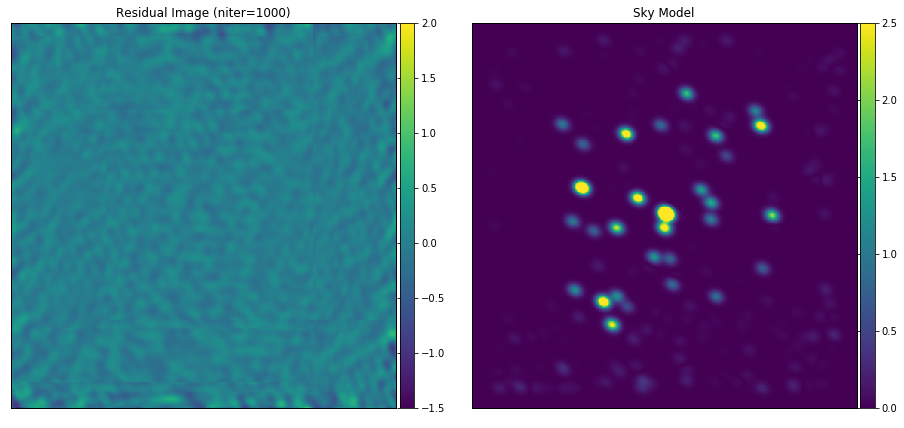

In [4]:
fig = plt.figure(figsize=(16, 7))
    
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n1000-residual.fits')
residualImg = fh[0].data
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n1000-model.fits')
skyModel = fh[0].data
    
#generate a retored PSF beam image
restBeam = genRstoredBeamImg(
            '../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n1000-residual.fits')
    
#convolve restored beam image with skymodel
convImg = convolveBeamSky(restBeam, skyModel)
    
gc1 = aplpy.FITSFigure(residualImg, figure=fig, subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-1.5, vmax=2, cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('Residual Image (niter=1000)')
gc1.add_colorbar()
    
gc2 = aplpy.FITSFigure(convImg, figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=0., vmax=2.5, cmap='viridis')
gc2.hide_axis_labels()
gc2.hide_tick_labels()
plt.title('Sky Model')
gc2.add_colorbar()
    
fig.canvas.draw()

图：1000次迭代后的残图和天空模型。过卷积的结果是噪声被加进了天空模型。
*Figure: residual image and sky model after 1000 deconvolution iterations. The residual image has been over-deconvolved leading to noise components being added to the sky model.*

为什么我们仍然要使用主观评价，这是有关好图像评价标准的第二个问题。当我们考虑实际的成像例子，对真实可见度执行去卷积操作的时候，我们总是或多或少会碰到校准误差问题。天文学家用选练有素的眼睛，可以识别出这些误差以及造成误差的原因，是增益校准不足，干扰问题，还是旁瓣太强，或者其它原因？这些问题会让卷积过程发散，产生不现实的天空模型。人眼非常擅长看出这些图像的问题，却又难以用图像处理技术加以描述，因此我们发现很难用算法来完成这件事情。

The second question of what makes a good image is why we still use subjective opinion. If we consider the realistic case of imaging and deconvolving a real set of visibilities then we have the added problem that there will be always be, at some level, calibration errors. These errors, and cause of these errors, can be identified by a trained eye whether it is poor gain calibration, interference, strong source sidelobes, or any number of other issues. Errors can cause a deconvolution process to diverge resulting in an unrealistic sky model. Humans are very good at looking at images and deciding if they make sense, but we can not easily describe how we do our image processing, thus we find it hard to implement algorithms to do the same. Looking at the dirty image and deconvolved image of the same field below most people would say the deconvoled image is objectively 'better' than the dirty image. Yet we do not know exactly why that is the case.

In [11]:
print(268740-(647+6561+4200+2400+3000+554+5725+2400)-12000-18800+5806*12)

282125


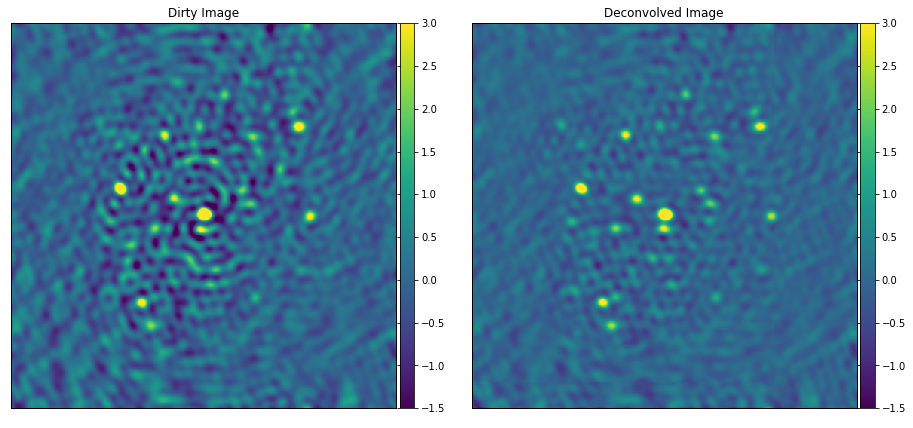

In [5]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-dirty.fits', \
                       figure=fig, subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-1.5, vmax=3., cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('Dirty Image')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-image.fits', \
                       figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-1.5, vmax=3., cmap='viridis')
gc2.hide_axis_labels()
gc2.hide_tick_labels()
plt.title('Deconvolved Image')
gc2.add_colorbar()

fig.canvas.draw()

左：KAT-7六小时观测脏图，赤纬$-30^{\circ}$。右：去卷积图像。

*Left: dirty image from a 6 hour KAT-7 observation at a declination of $-30^{\circ}$. Right: deconvolved image.*

跟脏图不一样，去卷积图像中，源周围少了噪声PSF结构。我们可以说，这些图像伪影是局部的，跟亮源的PSF响应有关。去卷积的目的在于去除这些PSF结构，用跟观测系统无关的简单的天空模型取而代之。理解并去除仪器效应，复原天空信号，这是射电干涉的难点工作。因此，为什么去卷积图像要优于脏图，我们对此有了一些理解，怎么对这些理解和人类直觉进行编码，从而实现对好图像的自动判断，这是留给我们，也是留给读者自己需要去面对的挑战。

The deconvolved image does not have the same noisy PSF structures around the sources that the dirty image does. We could say that these imaging artefacts are localized and related to the PSF response to bright sources. The aim of deconvolution is to remove these PSF like structures and replace them with a simple sky model which is decoupled fro the observing system. Most of difficult work in radio interferometry is the attempt to understand and remove the instrumental effects in order to recover the sky signal. Thus, we have some context for why the deconvolved image is 'better' than the dirty image. The challenge in automatically answering what makes a good image is some how encoding both the context and human intuition. Indeed, a challenge left to the reader.

### 6.4.1 动态范围和信噪比 Dynamic Range and Signal-to-Noise Ratio

动态范围是一个描述干涉图像质量的标准度量，已经使用了几十年。动态范围（dynamic range，DR）定义为峰值流量$I_{\textrm{peak}}$跟图像噪声标准差$\sigma_I$之比，可以为脏图或者去卷积图像计算动态范围。

Dynamic range is the standard metric, which has been used for decades, to describe the quality of an interferometric image. The dynamic range (DR) is defined as the ratio of the peak flux $I_{\textrm{peak}}$ to the standard deviation of the noise in the image $\sigma_I$. The dynamic range can be computed for either a dirty or deconvolved image.

$$\textrm{DR} = \frac{I_{\textrm{peak}}}{\sigma_I}$$

目前，动态范围的定义尚不明确。首先，怎么定义峰值流量？一般来说，图像中的峰值像素值被视为峰值流量。但是，改变图像分辨率将导致不同的像素流量值。降低分辨率会造成单个像素中包含更多的流量，同样，增加分辨率将导致流量被分散到多个像素。第二个问题是，怎么计算图像噪声？有以下几种方案：

1. 计算全图
2. 计算整个残图
3. 对图像随机采样
4. 选择一片相对空的区域

Now this definition of the dynamic range is not well defined. First, how is the peak flux defined? Typically, the peak pixel value anywhere in the image is taken to be the peak flux. But, be careful, changing the resolution of the image will result in different flux values. Decreasing the resolution can result in more flux being included in a single pixel, likewise by increasing the resolution the flux will be spread across more pixels. The second issue is how the noise of the image is computed, possible options are:

1. Use the entire image
2. Use the entire residual image
3. Randomly sample the image
4. Choose a 'relatively' empty region

这里没有列出所有方法，但典型的方法是选项4。去卷积以后，把图像载入到看图工具，选择一片没有源的相对空白区域，计算出该区域的噪声标准差。写到这里，我意识到这看上去很是荒谬。用不同的方法计算同一张图的动态范围，我们可以看到所算出的动态范围的变化。下面是算出的去卷积图的动态范围：

This is not an exhaustive list of methods, but the typical method is option 4. After deconvolution, the image is loaded into a viewer and the standard deviation of the noise is computed from a region the relatively free of sources. As I write this I am aware of how ridiculous that might sound. Using the same image we can see how the dynamic range varies by using these different methods. The dynamic range for the image deconvolved image above is:

In [12]:
#load deconvolved image
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-image.fits')
deconvImg = fh[0].data
#load residual image
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-residual.fits')
residImg = fh[0].data

peakI = np.max(deconvImg)
print('Peak Flux: %f Jy'%(peakI))

print('Dynamic Range:')
#method 1
noise = np.std(deconvImg)
print('\tMethod 1:', peakI/noise)

#method 2
noise = np.std(residImg)
print('\tMethod 2:', peakI/noise)

#method 3
noise = np.std(np.random.choice(deconvImg.flatten(), int(deconvImg.size*.01))) #randomly sample 1% of pixels
print('\tMethod 3:', peakI/noise)

#method 4, region 1
noise = np.std(deconvImg[0,0,0:128,0:128]) #corner of image
print('\tMethod 4a:', peakI/noise)

#method 4, region 2
noise = np.std(deconvImg[0,0,192:320,192:320]) #centre of image
print('\tMethod 4b:', peakI/noise)

Peak Flux: 9.632476 Jy
Dynamic Range:
	Method 1: 27.607452
	Method 2: 37.685246
	Method 3: 19.749033
	Method 4a: 38.25636
	Method 4b: 11.866578


方法1算出的动态范围总是比方法2小，因为方法2算的是残图，方法1算的是去卷积图，其中包括了源。方法3的结果跟参与计算的像素有关，如果随机采样的像素都含有源，则算出的标准差会偏大。方法4取决于用于计算噪声的区域，方法4a用了左下脚区域，其中没有源，所以得到了较高的动态范围，而方法4b用了中心区域，算出的噪声标准差较大，得到了较低的动态范围。方法不同，算出的动态范围结果不同，这就使得人们像是在玩一个“动态范围游戏”，可以根据自己的需求选择最适合的结果。一定要注意的是，要确保你的动态范围定义明确不带偏见。

Method 1 will always result in a lower dynamic range than Method 2 as the deconvoled image includes the sources where method 2 only uses the residuals. Method 3 will result in a dynamic range which varies depending on the number of pixels sampled and which pixels are sampled. One could imagine an unlucky sampling where every pixel chosen is part of a source, resulting in a large standard deviation. Method 4 depends on the region used to compute the noise. In the Method 4a result a corner of the image, where there are essentially no sources, results in a high dynamic range. On the other hand, choosing the centre region to compute the noise standard deviation results in a low dynamic range. This variation between methods can lead to people playing 'the dynamic range game' where someone can pick the result that best fits what they want to say about the image. Be careful, and make sure your dynamic range metric is well defined and unbiased.

对于以人机交互的方式计算图像噪声和动态范围，我们可以作出定性解释。人类很擅长图像处理，能快速选择出类似噪声的区域，只需要简单看一眼，就能想出复杂算法找出这些区域。动态范围涉及到一系列问题，跟图像质量有关。给定一个可见度数据集，提高其图像的动态范围通常会导致图像质量的改善，这是人为决定的。

There is a qualitative explanation for computing the image noise and the dynamic range by human interaction. Humans are very good at image processing, so we can quickly select regions which are 'noise-like', so it is easier to just look at an image then to try to come up with a complicated algorithm to find these regions. The dynamic range has a number of issues, but it is correlated with image quality. For a fixed visibility set, improving the dynamic range of an image usually results in a improvement in the quality of the image, as determined by a human.

使用动态范围的一个显著缺点在于它是一个全局度量，把图像缩减成了单个数字，不能提供图像的局部信息。这是现代综合成像的一个重要问题，因为主波束在成像中起到举足轻重的作用，必须考虑到方向依赖效应。这些问题将在第七章讨论到，但是，在 [<cite data-cite='taylor1999synthesis'>Synthesis Imaging in Radio Astronomy II (Lecture 13) </cite> &#10548;](http://adsabs.harvard.edu/abs/1999sira.conf.....T)中提到，可以把动态范围看成是一个评价图像质量的有效参数，动态范围是一个度量图像质量的标准方法。

A significant disadvantage to using dynamic range is that it is a global metric which reduced an image down to a single number. It provides no information about local artefacts. This is becoming an important issue in modern synthesis imaging as we push into imaging significant portions of the primary beam and need to account for direction-dependent effects. These topics are discussed in Chapter 7. But, as is noted in [<cite data-cite='taylor1999synthesis'>Synthesis Imaging in Radio Astronomy II (Lecture 13) </cite> &#10548;](http://adsabs.harvard.edu/abs/1999sira.conf.....T) an valid argument can be made for using dynamic range as a proxy (at least a partial one) for image quality. As of this writing dynamic range is the standard method to measure image quality.

### 6.4.2 残图 The Residual Image

我们已经知道，通过执行去卷积过程，我们得到了一个天空模型和残图。残图示例如下。

We have noted that the results of a deconvolution process is a sky model and a residual image. An example residual image is shown below.

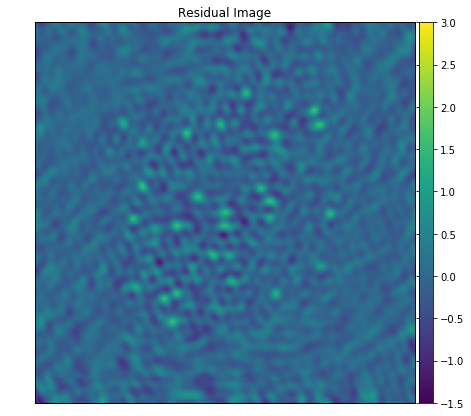

In [7]:
fig = plt.figure(figsize=(8, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-residual.fits', \
                       figure=fig)
gc1.show_colorscale(vmin=-1.5, vmax=3., cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('Residual Image')
gc1.add_colorbar()

fig.canvas.draw()

图：去卷积后的KAT-7观测残图。

*Figure: Residual image of a KAT-7 observation resulting from CLEAN deconvolution.*

该图显示，大多数亮源已经被去卷积，只剩下一些残余流量。因此，亮源所在的图像中央区域，其噪声要强于较弱源的边缘区域，因为主波束在中央区域最敏感。可以对残图做进一步的去卷积，但是来自源的剩余流量已接近图像噪声水平，会面临对噪声去卷积的危险。

The image shows that most of the sources bright sources have been deconvolved, but some flux remains. Thus, the centre of the image, where the brightest sources are, is noisier than the edges where the sources are weaker. This is typical as the primary beam is most sensitive at it's centre. This residual image could possibly be further deconvolved but the remaining flux from the sources is close to the image noise and we are in danger of deconvolving into the noise.

通过残图，我们可以了解到去卷积的情况和校准过程。理想的残图应该全部是噪声，不带明显结构。现实中很少见，因为总是存在去卷积或者校准伪影。从残图上我们可以看出，是否存在校准不良的基线，是否有RFI，是否去卷积不充分，去卷积参数是否正确，是否做了w项改正，有没有考虑方向依赖效应，留下了扩展结构以及其它效应。需要具备长期训练所获得的直觉，才能从残图上观察出这些效应。

The residual image provides the best insight to how well the deconvolution and calibration process was preformed. The ideal residual image is completely noise-like with no apparent structure throughout. This ideal is rarely reached as there is often deconvolution or calibration artefacts present. Looking at the residual image you can determine if there are poorly calibrated baselines, RFI present, not enough devolution, the wrong deconvolution parameters, the w-term correction has not been applied, there are direction-dependent effects unaccounted for, remaining extended structure, or any number of other effects. Inspection of the residual image for these different effects requires intuition which will develop with time.

### 6.4.3 图像质量评价 Image Quality Assessment

合成图像的质量评价是干涉测量的一个未解决的问题。默认情况下，我们采用人工主观评价，但是，这种方法很不科学，对同一幅图像会得到不同的质量度量。本节希望用更好的方法来解决图像质量评价的问题。

Assessing the quality of a sythnesized image is an open problem in interferometry. By default we use subjective human assessment. But this approach is not very scientific and can result in different measures of quality for the same image. With any hope this section will soon be expanded with better solutions to the image quality assessment problem.

去卷积过程生成了一个天空模型，但是该模型可能并不现实，因为在CLEAN中，即便是扩展源，天空模型也只是一组$\delta$函数。我们可以在此基础上，通过使用源搜索技术，确定天空模型中哪些是孤立源，哪些是扩展源，哪些是去卷积过程引入的噪声。这将在下一节讨论到。

The process of deconvolution produces a sky model, but that model may not be realistic in `CLEAN` where the sky model is a set of $\delta$-functions even if a source is extended. We can take sky modelling one step further by using source finding techniques to determine what in the sky model is an isolated source, what is a collection of nearby components which make up an extended source, or what is noise which resulted from an imperfect deconvolution. This will be discussed in the next section.

***

Next: [6.5 Source Finding and Detection](6_5_source_finding.ipynb)

<div class=warn><b>Future Additions:</b></div>

* examples of under and over deconvolution
* examples of poor deconvolution of extended sources with CLEAN
* example: deconvolve the same field (cygnus a?) with different methods and show results
* examples: sources of imaging artefacts, need real data examples